In [1]:
import sys
(sys.path).insert(1,'/Users/pedroguicardi/Desktop/CMB_Analysis/MAPSIMS/directories')

import mapsims
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from ad_fns import *
from astropy.io import fits
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ccat_models import ccat_noise as CCAT_noise
import scipy.optimize as op

In [2]:

NSIDE = 512
lat_lmax = 1500
sim_num = 20
output_file = "sims_output_1"
pysm_string = "d0,s0"


noise = mapsims.SONoiseSimulator(
        nside=NSIDE,
        return_uK_CMB = True,
        sensitivity_mode = "baseline",
        apply_beam_correction = False,
        apply_kludge_correction = False,
        homogeneous=False,
        rolloff_ell = 50,
        ell_max = lat_lmax,
        survey_efficiency = 1.0,
        full_covariance = False,
        LA_years = 5,
        LA_noise_model = "CcatLatv2b",
        elevation = 50,
        SA_years = 5,
        SA_one_over_f_mode = "pessimistic"
    )

def read_sims(sim_num, noise, NSIDE, output_file, pysm_string, apodize=False):
    "output shape will be of the form (bands_#, sim_num , 3, n_pix)"
    chs = ["LC1","LC1","LC2","LC2","LC3"]
    bands = [noise.tubes['LC1'][0].tag, noise.tubes['LC1'][1].tag,noise.tubes['LC2'][0].tag, noise.tubes['LC2'][1].tag,noise.tubes['LC3'][0].tag]
    output = np.zeros((5,sim_num, 3, 12*(NSIDE)**2))
    for j in np.arange(sim_num):
        for k in np.arange(5):
            tmp = hp.fitsfunc.read_map(output_file +"/"+bands[k]+"_" + chs[k]+"_NSIDE_" + str(NSIDE) + "_TAG_" + pysm_string + "_" + str(j) + "_" +".fits", field=(0,1,2))
            if apodize:
                for h in np.arange(tmp.shape[0]):
                    tmp[h,:] = apodize_map(tmp[h,:])
                    
            output[k,j,:,:] = tmp
    return output
    
    
    
sim_data = read_sims(sim_num,noise, NSIDE, output_file, pysm_string, apodize = False)
print(sim_data.shape)
print((sim_data[0,0,0]==sim_data[0,4,0]).all())

(5, 20, 3, 3145728)
False


Compute Power Spectra:

In [3]:
pow_specs = np.zeros((sim_data.shape[0], sim_data.shape[1], 6, lat_lmax+1))
for i in np.arange(sim_data.shape[0]):
    for j in np.arange(sim_data.shape[1]):
        pow_specs[i,j,:,:] = hp.sphtfunc.anafast(sim_data[i,j,:,:], lmax = lat_lmax)
        
avg_spec = np.mean(pow_specs, axis=1)
std_spec = np.std(pow_specs,axis=1)
print(avg_spec.shape, std_spec.shape)

(5, 6, 1501) (5, 6, 1501)


Very naive cross-spectrum for now: $C^{v_1 \times v_2}_\ell = \sqrt{C^{v_1}_\ell \cdot C^{v_2}_\ell }$  (just to get the dimensions right)

see below for further options: 

https://healpy.readthedocs.io/en/v1.9.0/generated/healpy.projaxes.HpxCartesianAxes.csd.html

ccs.fau.edu/~bressler/EDU/STSA/Modules/X.pdf

https://watermark.silverchair.com/stv1733.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAuAwggLcBgkqhkiG9w0BBwagggLNMIICyQIBADCCAsIGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMExQCXcC1xMfakDMjAgEQgIICkzdG3ykV_jk6uPWgnGl5JmunjJ0Qz1e1r5c-vI8RISplsK51DCus3qmJIfKAdzBnAyFIP4RItZp51Us7Ayv0OSLQS2JzZLt2pHTGpbwPK1Ldo_mJq7eEHoI6Hep7gDnWupc4_r05d261lFax9dSf9hvkhCzIP5GmPERzkenIrnqvqusnSlokdF8vF_0BYJclRnphpBcf5ATceYjpszw0X5dHLw-BKT1kpDzUQuKGKb_ZNbKi6DPehCMlNkneLfIN8SmIVGcU55iDVha_PLfbi7a1LDDZn2t78ZMZpMFuyNEvYLLr2NGgwJHtIcHjEDg9e0EOWUpeXam-a9opsyn-EZAJjZ4OAAWwEcjWyTLJjBhAg-CwcCdwXgKSm3RzAes-Jn68GJIMCQEXBEIz5ozKeecTRW2ejSVd7WuyHEl_gOvXZGM0DKIU-4HnMqXMvnR3ohf5912qM3kQaaaGB9qpiP08fuSGmrmCZvGtJdFG794pPk6SXewf5OP8x8jTjWxv3NeflH8y0D172c8HbCuLgn3UqfgXUKtvuY65ld6BzkTCPMwZPK8T2dlB1pDcAmxIzhKEtWd48Il2zPNtwAMSaETj0L2WHCZzaD55oahtpN4PPCDiQZCjqU7eFfkoff9-Ml__0PSxP9bs3PYzcWCcZjHwGu-W2ND-Q8B6qRGv90BocRGP0Z05E3gKFu1GDPHSSml9bwzbNN2nm2MW9efge2G0IWxFOkyVZo-Qwzgldd4z9ZvSlgK7vynEANwm7CtmkMYV0nK4Yw1HhSVthsDYzEI2mfRcdsh8OFUySpK9jupvNplPqWyA3Bl11NWv_Y8koQ7Y23Tt3Iuf5SpgFDpstNnFnlHhLbHlE5dvSopt2L3OE7D4


We will most likely end up altering the map $\rightarrow$ power spec step?

In [4]:
print(pow_specs.shape)

(5, 20, 6, 1501)


In [13]:
def naive_cross_freq_spectra(pow_spec_matrix, index, many = True):
    """pow_spec_matrix should be of the form (freqs,mutiple sims (optional), polarization, C_l)
    return will be of the form: (freq, freq, sims_index, C_l)"""
    if many == False:
        freq_only = pow_spec_matrix[:,index,:]
        ss = freq_only.shape
        freq_only = freq_only.reshape(ss[0], 1, ss[1])
    else:
        freq_only = pow_spec_matrix[:,:,index,:]
    n = freq_only.shape[0]
    M_cross_spec = np.zeros((n,n,freq_only.shape[1], freq_only.shape[2]))
    for i in np.arange(n):
        for j in np.arange(n):
            if i<=j:
                M_cross_spec[i,j,:,:] = np.sqrt(freq_only[i,:,:]*freq_only[j,:,:])
            else: 
                M_cross_spec[i,j,:,:] = M_cross_spec[j,i,:,:]
    return M_cross_spec

M_BB = naive_cross_freq_spectra(pow_specs, 2, many = True)

    
    

In [6]:
M_BB_avg = np.mean(M_BB, axis = 2)
M_BB_std = np.std(M_BB, axis = 2)

for i in np.arange(M_BB.shape[0]):
    print((M_BB_avg[i,i,:] == avg_spec[i,2,:]).all())
    print((M_BB_std[i,i,:] == std_spec[i,2,:]).all())
    

True
True
True
True
True
True
True
True
True
True


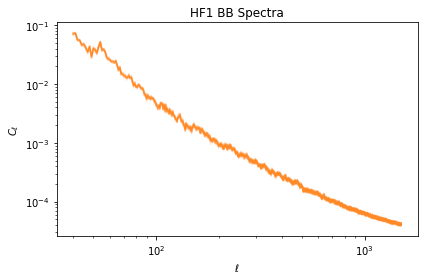

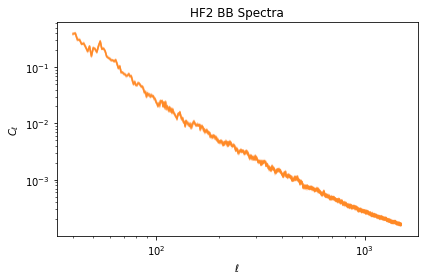

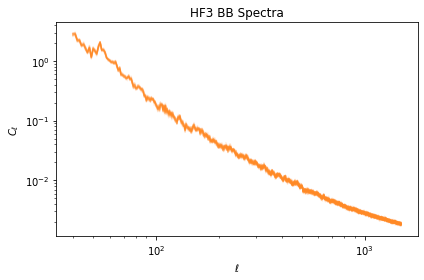

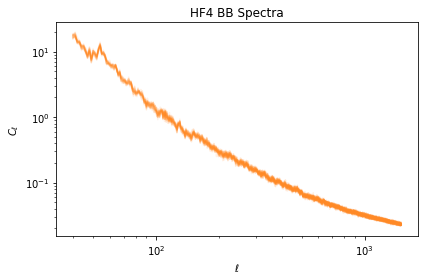

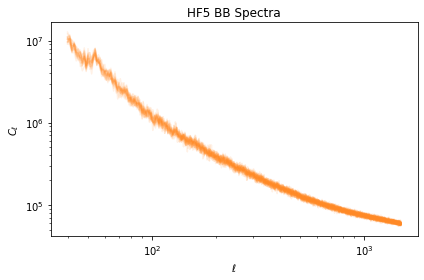

<Figure size 432x288 with 0 Axes>

In [7]:
lec = 40
hec = avg_spec.shape[-1] - 5
chs = np.array(["HF1","HF2","HF3","HF4","HF5"])
ell = np.arange(avg_spec.shape[-1])
for i in np.arange(chs.shape[0]):
    for j in np.arange(pow_specs.shape[1]):
        plt.plot(ell[lec:hec],pow_specs[i,j,2][lec:hec],"C1",  alpha = 0.1)
    plt.title(chs[i]+" BB Spectra")
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    plt.clf()

Looks a bit weird perhaps?? These similar patterns across frequencies do not make sense to me.

Plot averaged Temperature spectra:

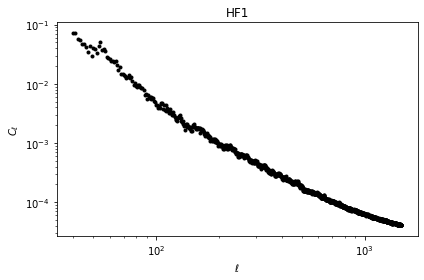

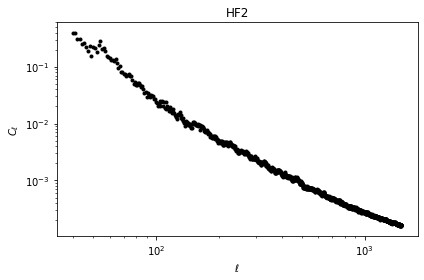

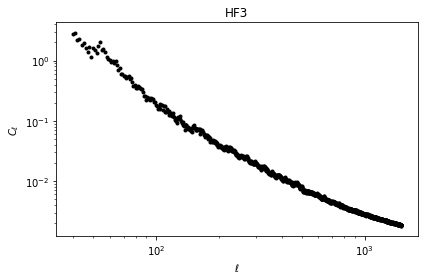

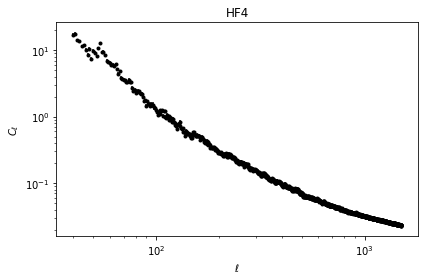

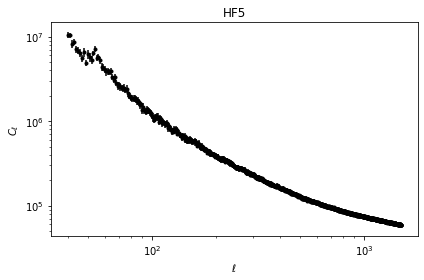

<Figure size 432x288 with 0 Axes>

In [8]:
chs = ["HF1","HF2","HF3","HF4","HF5"]
ell = np.arange(M_BB_avg.shape[-1])
color_bar = ['g','b','r','c','m']
for i in np.arange(5):
    plt.errorbar(ell[lec:hec], M_BB_avg[i,i][lec:hec], fmt=".k", yerr=M_BB_std[i,i,lec:hec], capsize=0, color = color_bar[i])
    plt.title(chs[i])
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    plt.clf()

In [54]:
plt.rcParams["figure.figsize"] = (10,6)
import fgspectra.cross as fgc
from fgspectra.frequency import _rj2cmb

# GET THEORETICAL POWER LAW CROSS SPECTRA for s0,d0
channel_list = [noise.tubes['LC1'][0],noise.tubes['LC1'][1], noise.tubes['LC2'][0],noise.tubes['LC2'][1],noise.tubes['LC3'][0]]

nu = np.array([channel_list[0].center_frequency.value,
               channel_list[1].center_frequency.value, 
               channel_list[2].center_frequency.value,
               channel_list[3].center_frequency.value,
               channel_list[4].center_frequency.value])
dust_params = dict(nu=nu, beta=1.54, temp=20., nu_0=353.)
sync_params = dict(nu=nu, beta=-3., nu_0=23.)
frequency_params = dict(kwseq=(dust_params, sync_params))

power_params = dict(
    ell=np.arange(1500)[1:],
    alpha=np.array([-2.8, -2.4]),  # +2 to (almost) get D_ell
    ell_0=84,
    amp=np.array([0.012 , 0.002])#*(10**0.5)
    ,rho=0.045
)

dust_sync = fgc.CorrelatedDustSynchrotron()

cl = dust_sync(frequency_params, power_params)*8*np.pi**2
conv_factors = np.outer(_rj2cmb(nu),_rj2cmb(nu)).reshape(len(nu),len(nu),1)
cl= cl#*1/np.sqrt(conv_factors)


#GET NOISE POWER SPECTRA

def get_noise_spectra(ch_list, noise):
    pspec_matrix = np.zeros((2,3,3,noise.ell_max))
    for i,ch in enumerate(ch_list):
        ell_sim, ps_T, ps_P, fsky, wnoise_power, weightsMap = noise.get_noise_properties(ch)
        pspec_matrix[0,i] = ps_T
        pspec_matrix[1,i] = ps_P
       
    output = np.zeros((5,2,noise.ell_max))
    output[0] = pspec_matrix[:,0,0]
    output[1] = pspec_matrix[:,0,1]
    output[2] = pspec_matrix[:,1,0]
    output[3] = pspec_matrix[:,1,1]
    output[4] = pspec_matrix[:,2,0]
    return output

pspec_matrix= get_noise_spectra(["LC1", "LC2", "LC3"], noise)




[0, 1]
[2, 3]
[4, 4]


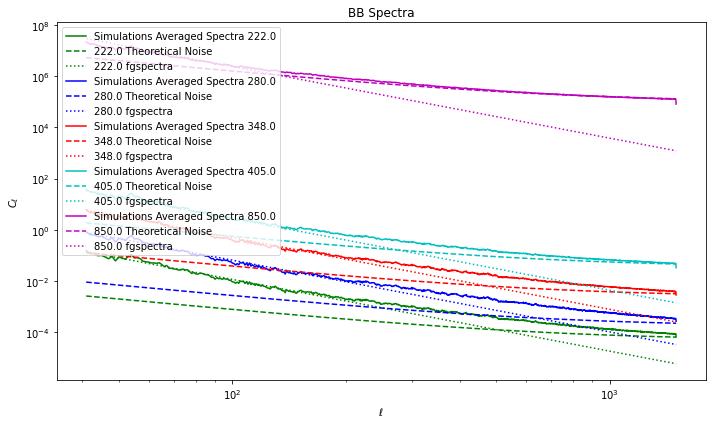

<Figure size 720x432 with 0 Axes>

In [62]:
#PLOT
lec =40
color_bar = ['g','b','r','c','m']
w = get_w(sim_data[0,0,2,:])
ell = np.arange(pspec_matrix.shape[-1])
for i in np.arange(nu.shape[0]):
#    plt.plot(cl[i,i], linestyle = "--",label = str(nu[i])+ ' Correlated Dust Synch Model fgspectra')
    plt.plot(ell[lec+1:],(avg_spec[i,2]/w)[lec+1:-1] , color=color_bar[i],label = 'Simulations Averaged Spectra ' +str(nu[i]))
    plt.plot(ell[lec+1:],M_noise[i,i][lec:], color=color_bar[i],linestyle = "--",label = str(nu[i])+ ' Theoretical Noise')
    plt.plot(ell[lec+1:],cl[i,i][lec:], linestyle = ":", color=color_bar[i], label =str(nu[i])+ ' fgspectra' )
    
plt.title('BB Spectra')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')
plt.show()
plt.clf()

They only agree with a scalar factor of $8\pi^2$ forced in.

In [59]:

M_noise = naive_cross_freq_spectra(pspec_matrix, 1, many = False)[:,:,:,1:]
M_noise = M_noise.reshape((M_noise.shape[0],M_noise.shape[1],M_noise.shape[-1]))
print(M_noise.shape)
print(M_BB_avg.shape)
print(cl.shape)
print(ell.shape)

(5, 5, 1499)
(5, 5, 1501)
(5, 5, 1499)
(1500,)


Maximum Likelihood Estimate:


$$log P(M_A, T)= -\frac{1}{2} \bigg( \sum_{\nu_1, \nu_2, \ell} \big( (M_A)_{\nu_1 \nu_2 \ell} - T_{\nu_1 \nu_2 \ell}\big)^2/(M_\sigma)_{\nu_1 \nu_2 \ell}^2
+ log(2\pi (M_\sigma)_{\nu_1 \nu_2 \ell}^2)\bigg)$$

Where $M_A$ is the averaged cross spectra, $M_\sigma$ the standard deviation matrix, and $T$ is given by:

$$T_{\nu_1 \nu_2 \ell} = \sqrt{C^{\nu_1}_{\ell,noise}C^{\nu_2}_{\ell,noise}} + F_{\nu_1 \nu_2 \ell}$$


Where $F_{\nu_1 \nu_2 \ell}$ are the values generated by fg spectra, which are entirely determined by $v_{par} = (A^{BB}_s, A^{BB}_d, \alpha_s, \alpha_d, \beta_s, \beta_d, \rho_{BB})$. 

We could also consider a shift: $(M_\sigma)_{\nu_1 \nu_2 \ell}^2 = (M_{std})_{\nu_1 \nu_2 \ell}^2 + \epsilon^2 T_{\nu_1 \nu_2 \ell}^2$ for small $\epsilon$

In [111]:
def log_likelihood(v_par, M_avg, M_std,M_noise, nu, ell_c):
    
    dust_params = dict(nu=nu, beta=v_par[5], temp=20., nu_0=353.)
    sync_params = dict(nu=nu, beta=v_par[4], nu_0=23.)
    frequency_params = dict(kwseq=(dust_params, sync_params))
    
    power_params = dict(
        ell=np.arange(ell_c[0], ell_c[1]),
        alpha=np.array([v_par[2], v_par[3]]),  # +2 to (almost) get D_ell
        ell_0=84,
        amp=np.array([v_par[0] , v_par[1]])#*(10**0.5)
        ,rho=v_par[6]
    )

    dust_sync = fgc.CorrelatedDustSynchrotron()

    cl = dust_sync(frequency_params, power_params)*8*np.pi**2
    T = M_noise[:,:,ell_c[0]:ell_c[1]] + cl
    M_sig2 = M_std[:,:,ell_c[0]: ell_c[1]]**2 + np.exp(v_par[7]*2) * T**2
    res = np.sum((M_avg[:,:,ell_c[0]: ell_c[1]] - T)**2 /M_sig2 + np.log(2*np.pi*M_sig2))
    return -res/2
    
    

In [112]:
lec = 40
hec = M_noise.shape[-1]
e=0.1
ell_c = [lec,hec ]
M_avg = M_BB_avg[:,:,1:-1]
M_std = M_BB_std[:,:,1:-1]
log_likelihood([0.012 , 0.002, -2.8, -2.35, -3.0, 1.53, 0.45,e],
               M_avg, 
               M_std,
               M_noise,  
               nu, 
               ell_c)


27393.5411044079

In [113]:
from scipy.optimize import minimize

np.random.seed(42)
v_par_o = np.array([0.012 , 0.002, -2.8, -2.35, -3.0, 1.53, 0.45,e])
nll = lambda *args: -log_likelihood(*args)
initial = v_par_o 
soln = minimize(nll, initial, args=(M_avg, M_std,M_noise, nu, ell_c))
sol = soln.x
print(sol.shape)

/home/pfg44/.local/lib/python3.6/site-packages/fgspectra-0.1-py3.6.egg/fgspectra/power.py:163: RuntimeWarning: invalid value encountered in sqrt
/home/pfg44/.local/lib/python3.6/site-packages/fgspectra-0.1-py3.6.egg/fgspectra/power.py:163: RuntimeWarning: invalid value encountered in sqrt


(8,)


In [116]:
def log_prior(v_par):
    allowed_devs = np.array([0.0015, 0.0001, 0.14, 0.0150, 0.14,0.012, 0.021, 0.1 ])
    v_par_o = np.array([0.012 , 0.002, -2.8, -2.35, -3.0, 1.53, 0.45, 0.1])
    if (v_par_o+allowed_devs>= v_par).all() and (v_par_o-allowed_devs<= v_par).all():
        return 0.0
    else:
        return -np.inf
    
def log_probability(v_par, M_avg, M_std,M_noise, nu, ell_c):
    lp = log_prior(v_par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(v_par,M_avg, M_std,M_noise, nu, ell_c)



import emcee

pos = np.array([0.012 , 0.002, -2.8, -2.35, -3.0, 1.53, 0.45,e])+ 1e-4 * np.random.randn(32,v_par_o.shape[0] )
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(M_avg, M_std, M_noise, nu, ell_c)
)
sampler.run_mcmc(pos, 500, progress=True);


You must install the tqdm library to use progress indicators with emcee


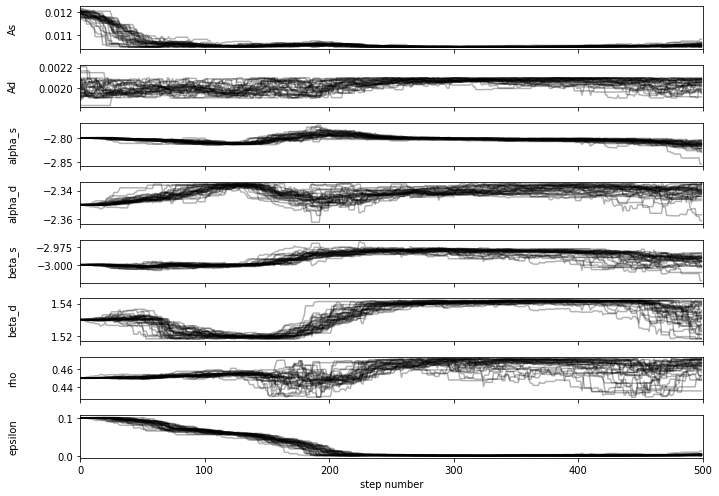

In [117]:
fig, axes = plt.subplots(v_par_o.shape[0], figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["As", "Ad", "alpha_s", "alpha_d", "beta_s", "beta_d", "rho","epsilon"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [118]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [42.67454118 50.1335411  29.12494873 32.35863163 50.33575855 54.16816563
 52.43688181 66.15546257]

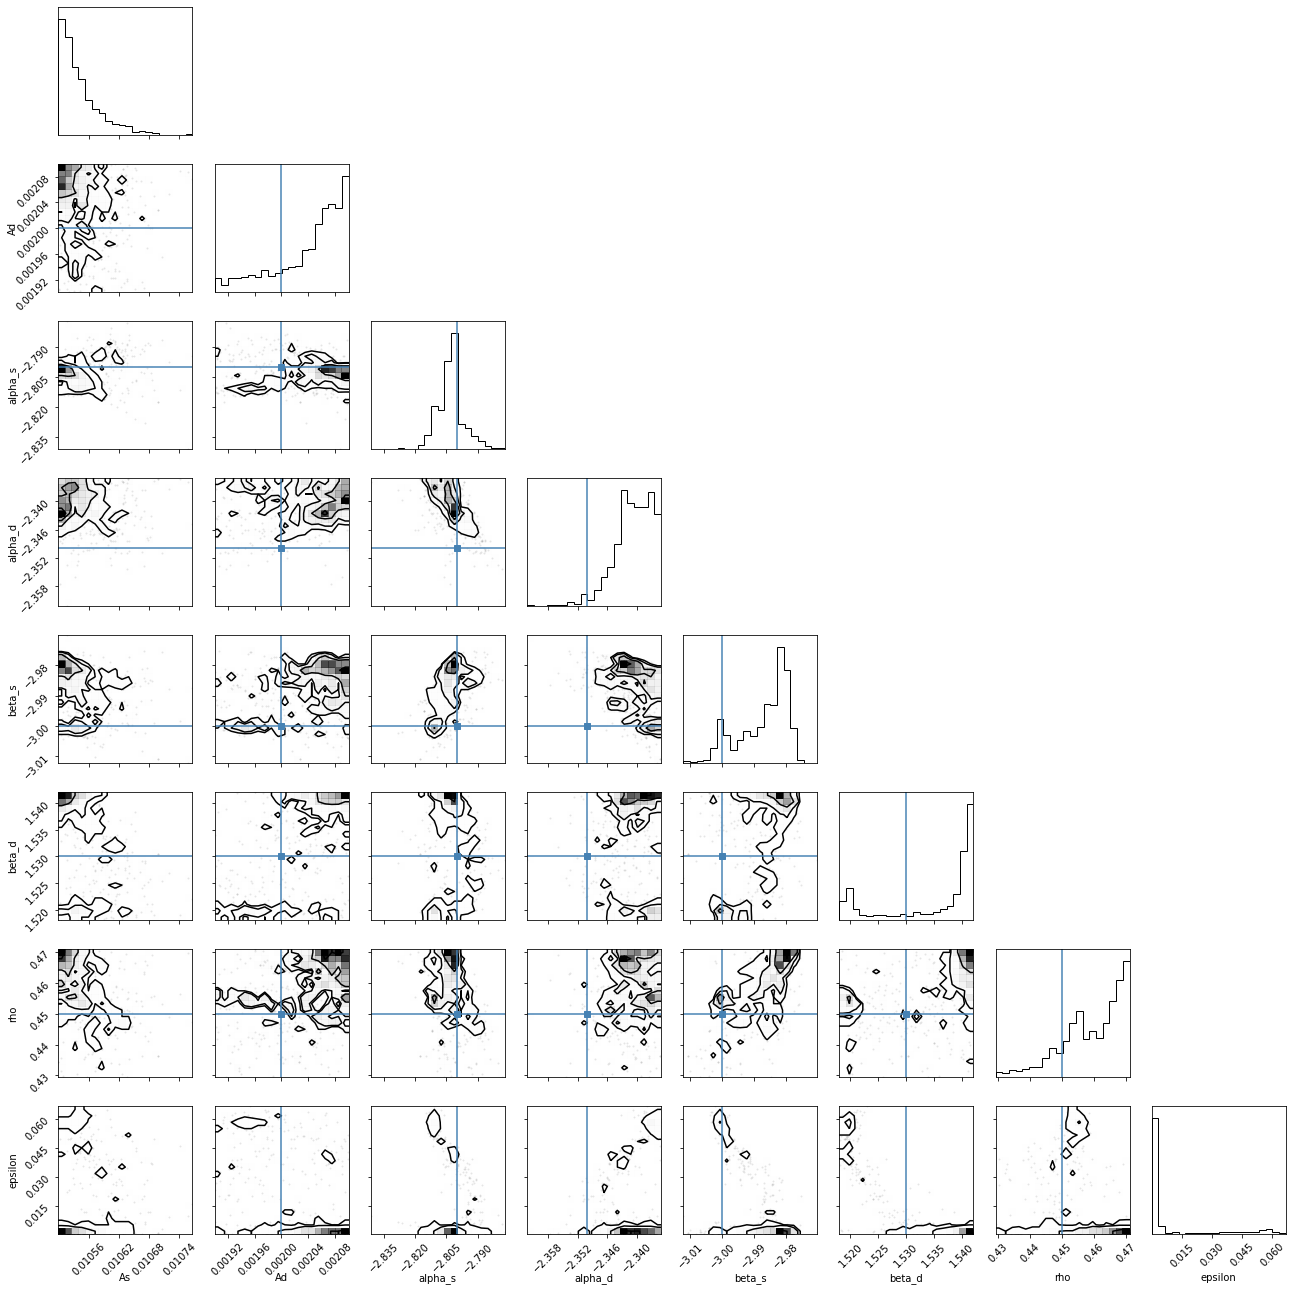

In [121]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, truths=v_par_o);



In [122]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>